### Keep_playing

In [1]:
import gym
import random
from gym import spaces

class KeepPlayingBlackjackEnv(gym.Env):
    def __init__(self, num_decks=6, turn_allowed = 5):
        super().__init__()
        
        self.num_decks = num_decks
        self.inner_turn = 0
        self.turn_allowed = turn_allowed-1
        self.reset_deck()
        
        self.action_space = spaces.Discrete(2)
        
        self.observation_space = spaces.Dict({
            "player_cards": spaces.MultiDiscrete([13] * 10),  
            "dealer_cards": spaces.MultiDiscrete([13] * 10),
            "remaining_deck": spaces.MultiDiscrete([52 * num_decks])
        })

    def reset_deck(self):
        self.deck = [i for i in range(1, 14) for _ in range(4 * self.num_decks)]
        random.shuffle(self.deck)

    def deal_card(self):
        return self.deck.pop()

    def calculate_hand_value(self, hand):
        value = sum(min(card, 10) for card in hand)  
        if 1 in hand and value + 10 <= 21:  
            return value + 10
        return value

    def reset(self):
        if self.inner_turn >= self.turn_allowed or len(self.deck) < 30:
            self.inner_turn = 0
            self.reset_deck()
        else:
            self.inner_turn += 1
        self.player_hand = [self.deal_card(), self.deal_card()] 
        self.dealer_hand = [self.deal_card(), self.deal_card()]  
        self.player_blackjack = (
            self.calculate_hand_value(self.player_hand) == 21 and len(self.player_hand) == 2
        )

        self.dealer_blackjack = (
            self.calculate_hand_value(self.dealer_hand) == 21 and len(self.dealer_hand) == 2
        )

        return self.get_state() 

    def get_state(self):
        remaining_deck = [self.deck.count(i) for i in range(1, 10)]  
        remaining_deck.append(sum(self.deck.count(i) for i in range(10, 14)))

        known_cards = self.dealer_hand[1:]
        
        for card in known_cards:
            remaining_deck[min(card-1,9)] += 1

        ace_usable = 0
        if 1 in self.player_hand and sum(min(card, 10) for card in self.player_hand) + 10 <= 21:
            ace_usable = 1

        return {
            "have_usable_ace": ace_usable,
            "player_cards": self.player_hand,
            "dealer_cards": self.dealer_hand[:1],  
            "remaining_deck": remaining_deck
        }
    
    def dealer_action(self):
        while self.calculate_hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deal_card())

    def step(self, action):
        if action == 0:  # Hit
            self.player_hand.append(self.deal_card())
            player_value = self.calculate_hand_value(self.player_hand)
            
            if player_value > 21: 
                return self.get_state(), -1, True, {}

            return self.get_state(), 0, False, {}  

        elif action == 1: 
            if self.player_blackjack:
                if self.dealer_blackjack:
                    return self.get_state(), 0, True, {}
                return self.get_state(), 1, True, {}
            if self.dealer_blackjack:
                return self.get_state(), -1, True, {}
            self.dealer_action()

            dealer_value = self.calculate_hand_value(self.dealer_hand)
            player_value = self.calculate_hand_value(self.player_hand)

            if dealer_value > 21 or player_value > dealer_value:
                return self.get_state(), 1, True, {}
            elif player_value < dealer_value:
                return self.get_state(), -1, True, {} 
            else:
                return self.get_state(), 0, True, {}

env = KeepPlayingBlackjackEnv(num_decks=2)
state = env.reset()

print(f"State: {state}")
      
done = False
while not done:
    action = random.choice([0, 1])
    state, reward, done, info = env.step(action)
    print(f"State: {state}, Reward: {reward}")


State: {'have_usable_ace': 1, 'player_cards': [13, 1], 'dealer_cards': [4], 'remaining_deck': [7, 8, 8, 7, 8, 8, 8, 8, 8, 31]}
State: {'have_usable_ace': 0, 'player_cards': [13, 1, 13], 'dealer_cards': [4], 'remaining_deck': [7, 8, 8, 7, 8, 8, 8, 8, 8, 30]}, Reward: 0
State: {'have_usable_ace': 0, 'player_cards': [13, 1, 13], 'dealer_cards': [4], 'remaining_deck': [7, 8, 8, 7, 8, 8, 8, 8, 8, 30]}, Reward: 1


In [2]:
import numpy as np
from collections import defaultdict
import random

env = KeepPlayingBlackjackEnv(num_decks=1)

Q = defaultdict(lambda: np.zeros(env.action_space.n))  

alpha = 0.1  
gamma = 0.99  
epsilon = 1.0 
epsilon_decay = 0.995  
min_epsilon = 0.01
num_episodes = 8000000  
turn = 0

def get_key(state):
    return (
        tuple(sorted([min(card, 10) for card in state["player_cards"]])), 
        tuple(min(card, 10) for card in state["dealer_cards"]),
        tuple(state["remaining_deck"]),  
        state["have_usable_ace"]
    )

for episode in range(num_episodes):
    state = get_key(env.reset())  
    done = False
    if env.inner_turn ==0:
        turn += 1
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  
        else:
            action = np.argmax(Q[state])  

        next_state, reward, done, _ = env.step(action)
        next_state = get_key(next_state)  
        
        best_next_action = np.argmax(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])
        
        state = next_state
    
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

print("\nDone!")
print(f" Q-table size: {len(Q)}")

Episode 1000/8000000 completed.
Episode 2000/8000000 completed.
Episode 3000/8000000 completed.
Episode 4000/8000000 completed.
Episode 5000/8000000 completed.
Episode 6000/8000000 completed.
Episode 7000/8000000 completed.
Episode 8000/8000000 completed.
Episode 9000/8000000 completed.
Episode 10000/8000000 completed.
Episode 11000/8000000 completed.
Episode 12000/8000000 completed.
Episode 13000/8000000 completed.
Episode 14000/8000000 completed.
Episode 15000/8000000 completed.
Episode 16000/8000000 completed.
Episode 17000/8000000 completed.
Episode 18000/8000000 completed.
Episode 19000/8000000 completed.
Episode 20000/8000000 completed.
Episode 21000/8000000 completed.
Episode 22000/8000000 completed.
Episode 23000/8000000 completed.
Episode 24000/8000000 completed.
Episode 25000/8000000 completed.
Episode 26000/8000000 completed.
Episode 27000/8000000 completed.
Episode 28000/8000000 completed.
Episode 29000/8000000 completed.
Episode 30000/8000000 completed.
Episode 31000/80000

In [3]:
import json
import numpy as np

def save_q_table_to_json(q_table, filename):
    q_table_serializable = {str(key): value.tolist() for key, value in q_table.items()}
    with open(filename, 'w') as f:
        json.dump(q_table_serializable, f)
        
name = 'Keep_playing_1_8000000.json'
save_q_table_to_json(Q, name)

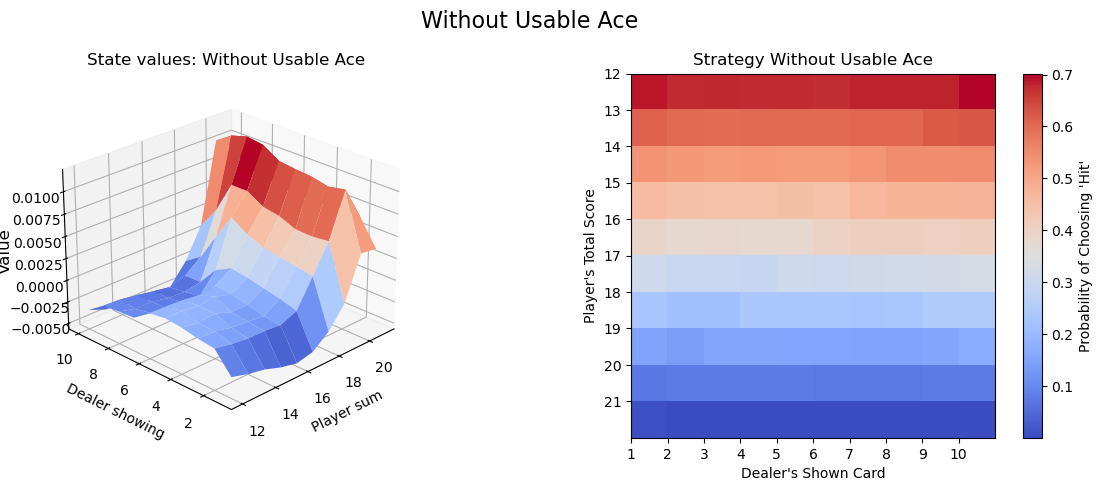

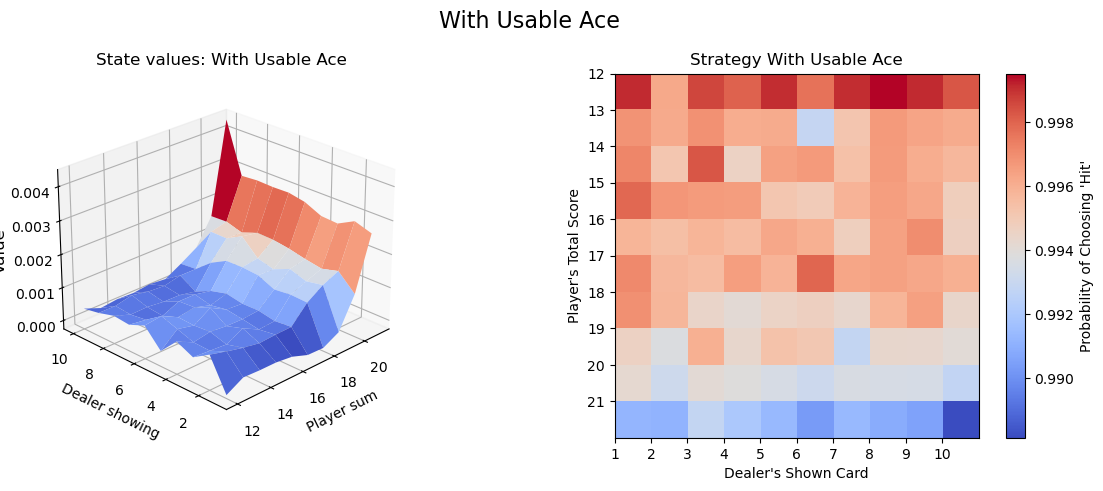

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def calculate_player_total(player_cards):
    total = sum(min(card, 10) for card in player_cards)  
    if 1 in player_cards and total + 10 <= 21:  
        return total + 10
    return total

def preprocess_q_table(Q):
    categorized_q = defaultdict(lambda: defaultdict(list))
    
    for state, q_values in Q.items():
        #print(type(state),state[0],'\n', q_values)
        #print(sum(min(card, 10) for card in state[0]))
        player_score = calculate_player_total(state[0])
        dealer_card = state[1][0]
        ace_flag = state[3]
        
        categorized_q[ace_flag][(player_score, dealer_card)].append(q_values)
    
    return categorized_q

def visualize_q_table_ace_split(Q):
    player_scores = range(12, 22)  
    dealer_shown_cards = range(1, 11)  
    
    categorized_q = preprocess_q_table(Q)

    for ace_flag, title in [(0, "Without Usable Ace"), (1, "With Usable Ace")]:
        strategy_prob = np.zeros((len(player_scores), len(dealer_shown_cards)))
        expected_value = np.zeros((len(player_scores), len(dealer_shown_cards)))

        for i, player_score in enumerate(player_scores):
            for j, dealer_card in enumerate(dealer_shown_cards):
                state_key = (player_score, dealer_card)
                if state_key in categorized_q[ace_flag]:
                    q_values_list = categorized_q[ace_flag][state_key]
                    hit_count = sum(np.argmax(q_values) == 0 for q_values in q_values_list)
                    state_count = len(q_values_list)
                    strategy_prob[i, j] = hit_count / state_count if state_count > 0 else -1
                    expected_value[i, j] = np.mean([min(1, max(-1, max(q_values))) for q_values in q_values_list]) if state_count > 0 else 0
                else:
                    strategy_prob[i, j] = -1 
            
        X, Y = np.meshgrid(player_scores, dealer_shown_cards)

        fig = plt.figure(figsize=plt.figaspect(0.4))
        fig.suptitle(title, fontsize=16)

        ax1 = fig.add_subplot(1, 2, 1, projection="3d")

        ax1.plot_surface(X, Y, expected_value.T, rstride=1, cstride=1, cmap="coolwarm", edgecolor="none")

        ax1.set_title(f"State values: {title}")
        ax1.set_xlabel("Player sum")
        ax1.set_ylabel("Dealer showing")
        ax1.zaxis.set_rotate_label(False)
        ax1.set_zlabel("Value", fontsize=12, rotation=90)
        ax1.view_init(25, 225)

        ax2 = fig.add_subplot(1, 2, 2)

        img = ax2.imshow(strategy_prob, cmap='coolwarm', interpolation='none', extent=[1, 11, 22, 12])
        cbar = fig.colorbar(img, ax=ax2) 
        cbar.set_label("Probability of Choosing 'Hit'")

        ax2.set_xticks(range(1, 11))
        ax2.set_yticks(range(12, 22))
        ax2.set_xlabel("Dealer's Shown Card")
        ax2.set_ylabel("Player's Total Score")
        ax2.set_title(f"Strategy {title}")

        plt.tight_layout()
        plt.show()

visualize_q_table_ace_split(Q)



 Action Distribution:
Hit: 66.23%
Stand: 33.77%


<Figure size 400x400 with 0 Axes>

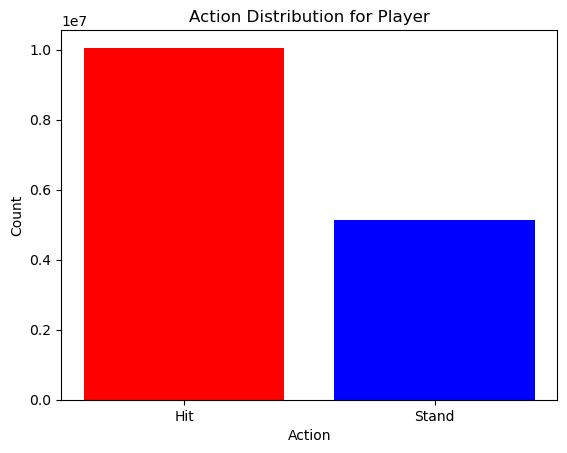

In [5]:
def analyze_action_distribution_Q(agent):
    action_counts = {0: 0, 1: 0}  # 0 = "Hit", 1 = "Stand"
    
    for state, q_values in agent.items():
        best_action = np.argmax(q_values)
        action_counts[best_action] += 1

    return action_counts

action_counts = analyze_action_distribution_Q(Q)
total_actions = sum(action_counts.values())

plt.figure(figsize=(4, 4))
print(f"\n Action Distribution:")
print(f"Hit: {action_counts[0] / total_actions:.2%}")
print(f"Stand: {action_counts[1] / total_actions:.2%}")

# Plot distribution
plt.figure()
plt.bar(["Hit", "Stand"], [action_counts[0], action_counts[1]], color=['red','blue'])
plt.title(f"Action Distribution for Player")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

In [29]:
def test_strategy(env, strategy, num_games=1000):
    wins = 0
    draws = 0
    losses = 0

    for _ in range(num_games):
        state = env.reset()
        done = False

        while not done:
            if strategy == 'random':
                action = env.action_space.sample() 
            elif strategy == 'dealer':
                player_total = sum(min(card, 10) for card in state['player_cards'])
                action = 0 if player_total < 17 else 1
            elif strategy == 'q_learning':
                state_str = get_key(state)
                if state_str in Q:
                    action = np.argmax(Q[state_str])  
                else:
                    action = env.action_space.sample()  

            state, reward, done, _ = env.step(action)
        
        if reward == 1:
            wins += 1
        elif reward == 0:
            draws += 1
        else:
            losses += 1

    win_rate = wins / num_games
    draw_rate = draws / num_games
    loss_rate = losses / num_games
    return win_rate, draw_rate, loss_rate

num_games = 1000
env = KeepPlayingBlackjackEnv(num_decks=1,turn_allowed=5)

random_win, random_draw, random_loss = test_strategy(env, 'random', num_games)
print(f"Random Strategy: Win={random_win*100:.2f}%, Draw={random_draw*100:.2f}%, Loss={random_loss*100:.2f}%")

dealer_win, dealer_draw, dealer_loss = test_strategy(env, 'dealer', num_games)
print(f"Dealer Strategy: Win={dealer_win*100:.2f}%, Draw={dealer_draw*100:.2f}%, Loss={dealer_loss*100:.2f}%")

q_learning_win, q_learning_draw, q_learning_loss = test_strategy(env, 'q_learning', num_games)
print(f"Q-Learning Strategy: Win={q_learning_win*100:.2f}%, Draw={q_learning_draw*100:.2f}%, Loss={q_learning_loss*100:.2f}%")


Random Strategy: Win=31.80%, Draw=4.00%, Loss=64.20%
Dealer Strategy: Win=39.60%, Draw=8.50%, Loss=51.90%
Q-Learning Strategy: Win=36.00%, Draw=5.80%, Loss=58.20%
